In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.metrics import roc_auc_score
import joblib

import flows as fnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

no_cuda=True
CUDA = not no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if CUDA else "cpu")
device = torch.device("cuda:2")

# Cofigure tunable params

In [2]:
mu_values = np.arange(0,50)/10
plotDir = "plots/Toy/"
nBins = 10
aug_NN = False # if training NN for data augmentation instead of LDA- feature removed

In [3]:
useAuxZMeasure = False
#useAuxZMeasure = True

if useAuxZMeasure:
    plotDir = "plots/Toy/AuxMeasure/"

In [4]:
clfCol = "b"; aweCol = "g"; augCol = "y"; invCol = "r"; clfNomCol = "k"

In [5]:
n_events = n_z = 2 * 10**6 # dataset size per z
feature_std = 0.7; r = 1. 

z_nominal = np.pi/4
z_std = 0.5

n_shifts = 21
syst_shifts = np.arange(0,21)/10 # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]
assert len(syst_shifts)==n_shifts
z_syst =  z_nominal * syst_shifts
systUp = z_nominal * syst_shifts[-1]

In [6]:
# This function returns the flow model
def get_flow_model(settings):
    modules = []
    for _ in range(settings['num_blocks']):
        modules += [
            fnn.MADE(settings['num_inputs'], settings['num_hidden'], num_cond_inputs=settings['num_cond'], act=settings['activation'],
            pre_exp_tanh=settings['pre_exp_tanh']),
            fnn.Reverse(settings['num_inputs'])
        ]
    model = fnn.FlowSequential(*modules)
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                module.bias.data.fill_(0)
    model.to(settings['device'])
    return model    



# Generate Dataset

In [7]:

X_double_syst_train = []
Y_double_syst_train = []
Z_double_syst_train = []
weights_double_syst_train = []


n_data = 1000000
true_mu = 1; # variable never used

sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 

#sigScaling = 0.1
#backScaling = 0.1

n_shifts_train = 61
syst_shifts_train = np.arange(-20,41)/10
z_syst_train =  z_nominal * syst_shifts_train

mu_shifts_train = 51
mu_syst_train = np.arange(0,51)/10



for mu_syst in mu_syst_train:

    X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, int(n_data*mu_syst*sigScaling)), 
                                             np.random.normal(0, feature_std, int(n_data*mu_syst*sigScaling))]).T 
                  for i in range (n_shifts_train)])
    Y_sig_syst_train = np.array([np.ones(int(n_data*mu_syst*sigScaling)) for i in range (n_shifts_train)])
    centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), 
                                                     np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
    X_sig_syst_train += centres_sig_syst_train

    X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, int(n_data*backScaling)), 
                                              np.random.normal(0, feature_std, int(n_data*backScaling))]).T
                            for i in range (n_shifts_train)])
    Y_back_syst_train = np.array([np.zeros(int(n_data*backScaling)) for i in range (n_shifts_train)])
    centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), 
                                                      -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
    X_back_syst_train += centres_back_syst_train

    X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
    Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
    Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)

    weights_syst_train = np.ones_like(Y_syst_train)


    X_double_syst_train.append(X_syst_train)
    Y_double_syst_train.append(Y_syst_train)
    Z_double_syst_train.append(Z_syst_train)
    weights_double_syst_train.append(weights_syst_train)

    
    print(X_syst_train.shape[0], X_syst_train.shape, Y_syst_train.shape, Z_syst_train.shape)
    
    

#X_double_syst_train = np.array(X_double_syst_train)
#Y_double_syst_train = np.array(Y_double_syst_train)
#Z_double_syst_train = np.array(Z_double_syst_train)
#weights_double_syst_train = np.array(weights_double_syst_train)

#print(X_double_syst_train.shape, Y_double_syst_train.shape, Z_double_syst_train.shape, weights_double_syst_train.shape)


61 (61, 100000, 2) (61, 100000) (61, 100000)
61 (61, 100100, 2) (61, 100100) (61, 100100)
61 (61, 100200, 2) (61, 100200) (61, 100200)
61 (61, 100300, 2) (61, 100300) (61, 100300)
61 (61, 100400, 2) (61, 100400) (61, 100400)
61 (61, 100500, 2) (61, 100500) (61, 100500)
61 (61, 100600, 2) (61, 100600) (61, 100600)
61 (61, 100700, 2) (61, 100700) (61, 100700)
61 (61, 100800, 2) (61, 100800) (61, 100800)
61 (61, 100900, 2) (61, 100900) (61, 100900)
61 (61, 101000, 2) (61, 101000) (61, 101000)
61 (61, 101100, 2) (61, 101100) (61, 101100)
61 (61, 101200, 2) (61, 101200) (61, 101200)
61 (61, 101300, 2) (61, 101300) (61, 101300)
61 (61, 101400, 2) (61, 101400) (61, 101400)
61 (61, 101500, 2) (61, 101500) (61, 101500)
61 (61, 101600, 2) (61, 101600) (61, 101600)
61 (61, 101700, 2) (61, 101700) (61, 101700)
61 (61, 101800, 2) (61, 101800) (61, 101800)
61 (61, 101900, 2) (61, 101900) (61, 101900)
61 (61, 102000, 2) (61, 102000) (61, 102000)
61 (61, 102100, 2) (61, 102100) (61, 102100)
61 (61, 10

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.utils.weight_norm as weight_norm


class EPiC_layer(nn.Module):
    def __init__(self, local_in_dim, hid_dim, latent_dim, norm_fn):
        super(EPiC_layer, self).__init__()
        self.fc_global1 = norm_fn(nn.Linear(int(2*hid_dim)+latent_dim, hid_dim)) 
        self.fc_global2 = norm_fn(nn.Linear(hid_dim, latent_dim)) 
        self.fc_local1 = norm_fn(nn.Linear(local_in_dim+latent_dim, hid_dim))
        self.fc_local2 = norm_fn(nn.Linear(hid_dim, hid_dim))

    def forward(self, x_global, x_local):   # shapes: x_global[b,latent], x_local[b,n,latent_local]
        batch_size, n_points, latent_local = x_local.size()
        latent_global = x_global.size(1)

        x_pooled_mean = x_local.mean(1, keepdim=False)
        x_pooled_sum = x_local.std(1, keepdim=False)
        x_pooledCATglobal = torch.cat([x_pooled_mean, x_pooled_sum, x_global], 1)
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))  # new intermediate step
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global) # with residual connection before AF

        x_global2local = x_global.view(-1,1,latent_global).repeat(1,n_points,1) # first add dimension, than expand it
        x_localCATglobal = torch.cat([x_local, x_global2local], 2)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))  # with residual connection before AF
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_global, x_local





# This function returns the flow model
def get_flow_model_embed(settings):
    modules = []
    for _ in range(settings['num_blocks']):
        modules += [
            fnn.MADE(settings['num_inputs'], settings['num_hidden'], num_cond_inputs=settings['num_out_embed'], act=settings['activation'],
            pre_exp_tanh=settings['pre_exp_tanh']),
            fnn.Reverse(settings['num_inputs'])
        ]
    model = fnn.FlowSequential(*modules)
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                module.bias.data.fill_(0)
    model.to(settings['device'])
    return model    


weight_decay = 0.0e-6

# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 8,
    # number of nodes in hidden layers
    'num_hidden' : 64,
    # number of nodes in hidden layers
    'num_hidden_embed' : 32,
    # number of nodes in hidden layers
    'num_out_embed' : 32,
    # number of nodes in hidden layers
    'num_epic_latent' : 8,
    # number of nodes in hidden layers
    'num_epic_layer' : 5,
    # number of conditional variables
    'num_cond' : 2,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 


class EpicEmbeddingFlow(nn.Module):
    
    def __init__(self, settings):
        super(EpicEmbeddingFlow, self).__init__()
        
        self.equiv_layers = settings['num_epic_layer']
        
        norm_fn = weight_norm
        #norm_fn = lambda x:x
        
        
        self.fc_l1 = norm_fn(nn.Linear(settings['num_cond'], settings['num_hidden_embed']))
        self.fc_l2 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']))

        self.fc_g1 = norm_fn(nn.Linear(int(2*settings['num_hidden_embed']), settings['num_hidden_embed']))
        self.fc_g2 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_epic_latent']))

        self.nn_list = nn.ModuleList()
        for _ in range(self.equiv_layers):
            self.nn_list.append(EPiC_layer(settings['num_hidden_embed'], settings['num_hidden_embed'],
                                           settings['num_epic_latent'], norm_fn))
        
        self.fc_g3 = norm_fn(nn.Linear(int(2*settings['num_hidden_embed']+settings['num_epic_latent']), settings['num_hidden_embed']))
        self.fc_g4 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']))
        self.fc_g5 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_out_embed']))

        
        self.flow_model = get_flow_model_embed(settings).to(current_settings["device"])
  



    def embedd(self, x):
        # local encoding
        x_local = F.leaky_relu(self.fc_l1(x))
        x_local = F.leaky_relu(self.fc_l2(x_local) + x_local)

        # global features
        x_mean = x_local.mean(1, keepdim=False)  # mean over points dim.
        x_sum = x_local.std(1, keepdim=False)  # mean over points dim.
        x_global = torch.cat([x_mean, x_sum], 1)
        x_global = F.leaky_relu(self.fc_g1(x_global)) 
        x_global = F.leaky_relu(self.fc_g2(x_global))  # projecting down to latent size

        # equivariant connections
        for i in range(self.equiv_layers):
            x_global, x_local = self.nn_list[i](x_global, x_local)   # contains residual connection
        
        x_mean = x_local.mean(1, keepdim=False)  # mean over points dim.
        x_sum = x_local.std(1, keepdim=False)  # sum over points dim.
        x = torch.cat([x_mean, x_sum, x_global], 1)
        
        x = F.leaky_relu(self.fc_g3(x))
        x = F.leaky_relu(self.fc_g4(x) + x)
        x = self.fc_g5(x)
        return x





    def log_probs(self, inputs, cond_inputs = None, weights = None):
        
        cond_inputs = self.embedd(cond_inputs)
        
        #print(cond_inputs.shape)
        #print(cond_inputs)
        
        log_prob = self.flow_model.log_probs(inputs=inputs, cond_inputs=cond_inputs)

        return log_prob
    
    

    def sample(self, num_samples=None, noise=None, cond_inputs=None, weights = None):

        cond_inputs = self.embedd(cond_inputs)

        samples = self.flow_model.sample(num_samples=num_samples, noise=noise, cond_inputs=cond_inputs)
        
        return samples






In [122]:

epochs = 100


learning_rate = 1.0e-4
batch_per_slice = 10

#model = EpicEmbeddingFlow(current_settings).to(current_settings["device"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    model.train()
    now_loss = 0 
    
    permut_mu = np.random.permutation(len(X_double_syst_train))
    print(permut_mu)
    
    for i_mu in permut_mu:
        
        
        X_mu_slice_syst_train = X_double_syst_train[i_mu]
        weights_mu_slice_syst_train = weights_double_syst_train[i_mu]

        permut_batch = np.random.permutation(X_mu_slice_syst_train.shape[1])
        batch_size_internal = int(X_mu_slice_syst_train.shape[1]/batch_per_slice)        
        
        for i_bat in range(batch_per_slice):

            x_data = torch.tensor(X_mu_slice_syst_train[:, permut_batch[i_bat*batch_size_internal:(i_bat+1)*batch_size_internal]]
                                 ).to(current_settings["device"])#.view(1,-1)

            
            mu_data = torch.tensor(mu_syst_train[i_mu]).to(current_settings["device"]).expand(x_data.size(0))
            z_data = torch.tensor(z_syst_train).to(current_settings["device"])

            pad_data = (torch.torch.randn(z_data.size(0), 6)).to(current_settings["device"])

            inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1), pad_data), 1).float()/10.0


            cond_inputs = x_data

            optimizer.zero_grad()

            log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float())

            loss_vals = log_prob

            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()
            
            print(loss)

    print('Epoch: {:d}, Mu: {:.2f}, Loss: {:.4f}'.format(epoch, mu_syst_train[i_mu], loss))




#model = train_flow()


Starting epoch 1...
[14 39 42  9 23 12 27 38 33 26 44 30 11 20 28 13 34 15 24  5 41 22  0 43
  2 32 19 46 18 49 29 47 45  4  8 37 17 48  6 31 36  1 35 25 16 50  3 21
  7 10 40]
tensor(-4.8899, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-6.2012, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-6.7716, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-7.0178, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-7.3829, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-6.9492, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-6.8098, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-7.2740, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-7.1483, device='cuda:2', grad_fn=<NegBackward0>)
tensor(-7.5049, device='cuda:2', grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [10]:





torch.save(model.state_dict(), './EpicModel.pth')











[0.78539816]


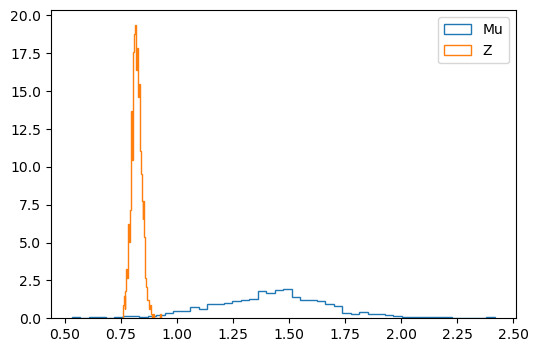

In [11]:
### Single experiment x1000 nominal z
n_data = 500000
mu_test = 1.0


n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling*mu_test)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])

print(Z_incarnation)

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


out = []
for i in range(0, 10):
    with torch.no_grad():
        
        batch_indices = np.random.permutation(X_data_nom[0].shape[0])
        #print(batch_indices)
        
        
        x_data_sort = X_data_nom[0][batch_indices]
        
        sort_ind = np.argsort(x_data_sort[:,0], axis=0)
        x_data_sort = x_data_sort[sort_ind]

        x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()

        cond_inputs = x_data.repeat((100, 1, 1))
        
        outputs_flow = model.sample(num_samples = 100, noise=None, 
                                    cond_inputs = cond_inputs, 
                                   ).cpu().numpy()*10.0
        out.append(outputs_flow)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
subplot.legend()


In [12]:
n_data = 5000000
mu_test = 1.0


n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
Z_incarnation = np.array([z_nominal])

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom
X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)


mu_range = np.arange(-0.0, 2.1, 0.1)

nll2d = np.zeros((len(mu_range), len(z_syst_train)))


for i, mu in enumerate(mu_range):
    for j, z in enumerate(z_syst_train):
        nll = []
        for k in range(0, 50):
            with torch.no_grad():

                batch_indices = np.random.permutation(X_data_nom[0].shape[0])[:size_batch]
                #print(batch_indices)


                x_data_sort = X_data_nom[0][batch_indices]

                sort_ind = np.argsort(x_data_sort[:,0], axis=0)
                x_data_sort = x_data_sort[sort_ind]

                x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()
                x_data = x_data.reshape(1,-1)

                cond_inputs = x_data
  
    
    
        
                mu_data = (torch.ones((x_data.size(0), 1))*mu).to(current_settings["device"])
                z_data  = (torch.ones((x_data.size(0), 1))*z).to(current_settings["device"])
                pad_data = (torch.torch.randn(x_data.size(0), 6)).to(current_settings["device"])


                inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1), pad_data), 1).float()/10.0
  
                log_prob = - model.log_probs(inputs, cond_inputs = cond_inputs)
            
                nll.append(log_prob.cpu().numpy())
            
        nll = np.array(nll)
        nll2d[i,j] = nll2d[i,j] + np.mean(nll)

    print(mu)
                


NameError: name 'size_batch' is not defined

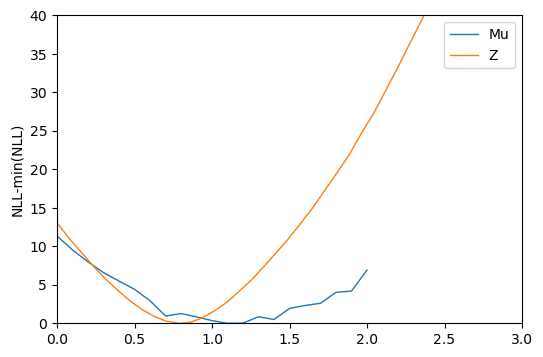

In [116]:
nll1d_mu = np.min(nll2d, 1)
nll1d_z = np.min(nll2d, 0)

fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

subplot.plot(mu_range, (nll1d_mu-min(nll1d_mu)), 
             label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.plot(z_syst_train, (nll1d_z-min(nll1d_z))/10, 
             label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0)
subplot.set_ylim(0, 40)
subplot.set_xlim(0, 3)
subplot.set_ylabel('NLL-min(NLL)')
subplot.legend()


0.21746104343232076 1.1368264808820603


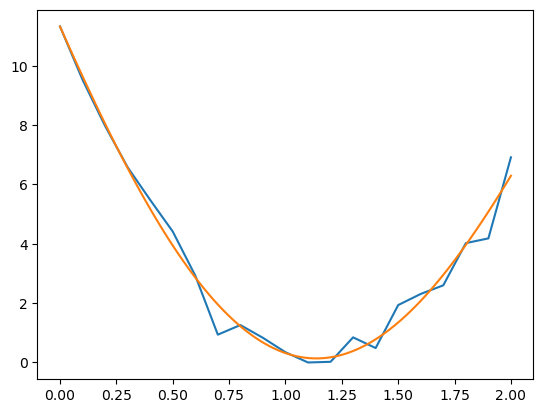

In [123]:
def ConfidenceIntervalls(mu_values, nll1D, central=1.0):
    z = np.polyfit(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1], 4)
    poly = np.poly1d(z)
    #1 Sigma = 0.5, 2 Sigma = 2, 3 Sigma = 4.5
    threshs = [0.5, 2.0, 4.5]
    sigmas = [1.0, 2.0, 3.0]
    ret_intersects = []
    std = 0.0
    
    deriv1 = poly.deriv()
    deriv2 = poly.deriv(2)
    
    extr = (deriv1).roots
    minimum = extr[np.argsort(np.abs(extr-central))][0]
    
    assert deriv2(minimum) > 0
    
    
    for t,s  in zip(threshs, sigmas):
        intersects = (poly - t).roots
        # Select 2 roots closest to central value (only needed for polynomials with order > 2
        ret_intersects.append(intersects[np.argsort(np.abs(intersects-central))][:2])    
        std += (abs(ret_intersects[-1][0] - ret_intersects[-1][1])/(s*2))
        
    std = std/len(sigmas)
    
    plt.plot(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1], label='Data')
    plt.plot(np.linspace(central-1,central+1, 100), poly(np.linspace(0,2, 100)), label='Fit')
    return std, ret_intersects, minimum
    

sigma_NPE_nom, _, mu_NPE_nom = ConfidenceIntervalls(mu_values=mu_range, nll1D=(nll1d_mu-min(nll1d_mu)))

print(sigma_NPE_nom, mu_NPE_nom)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.utils.weight_norm as weight_norm




def _loop_mean(x, ind_list, axis=0):
    """
        Helper function for quantile_means
        in cases where the number of quantiles is not evenly divisible
        by the number of points in the sample, array operations cannot
        be used for the slicing due to resulting in jagged output arrays. 
        This function uses a slower workaround that does not need consisten
        array sizes.
    """
    
    out_list = [] 
    for ind in ind_list:
        if axis==0:
            out_list.append(torch.mean(x[ind], keepdim=True, axis=axis))
        elif axis==1:
            out_list.append(torch.mean(x[:,ind], keepdim=True, axis=axis))
        elif axis==2:
            out_list.append(torch.mean(x[:,:,ind], keepdim=True, axis=axis))
        elif axis==3:
            out_list.append(torch.mean(x[:,:,:,ind], keepdim=True, axis=axis))
                
    return torch.cat(out_list, axis)


def quantile_means(x, axis=1, n_quant=100):
    """
        Split a given tensor into n_quant equially sized section 
        and calculate the mean over eath of the sections
        using more quantiles an point in the sample reduced in some 
        output means being zero
    """
    n_points = x.shape[axis]
    
    ind = np.arange(n_points)
    ind_list = []
    prev = 0

    for i in np.linspace(n_points/n_quant, n_points, n_quant):
        int_i = int(i)
        if int_i == prev:
            ind_list.append(np.array([]))
        else:            
            ind_list.append(np.array(ind[prev:int_i]))
        prev = int_i
    
    try:
        ind_list = np.array(ind_list)
        if axis==0:
            out = torch.mean(x[ind_list], axis=axis+1)
        elif axis==1:
            out = torch.mean(x[:,ind_list], axis=axis+1)
        elif axis==2:
            out = torch.mean(x[:,:,ind_list], axis=axis+1)
        elif axis==3:
            out = torch.mean(x[:,:,:,ind_list], axis=axis+1)

    except:
        out = _loop_mean(x, ind_list, axis)
            
    return out




class EPiC_layer_quant(nn.Module):
    def __init__(self, local_in_dim, hid_dim, latent_dim, norm_fn, n_quant):
        super(EPiC_layer_quant, self).__init__()
        self.norm_fn = norm_fn
        self.n_quant = n_quant

        self.fc_global1 = self.norm_fn(nn.Linear(int(self.n_quant*hid_dim)+latent_dim, hid_dim)) 
        self.fc_global2 = self.norm_fn(nn.Linear(hid_dim, latent_dim)) 
        self.fc_local1 = self.norm_fn(nn.Linear(local_in_dim+latent_dim, hid_dim))
        self.fc_local2 = self.norm_fn(nn.Linear(hid_dim, hid_dim))

    def forward(self, x_global, x_local):   # shapes: x_global[b,latent], x_local[b,n,latent_local]
        batch_size, n_points, latent_local = x_local.size()
        latent_global = x_global.size(1)

        x_pooled_mean = quantile_means(x_local, axis=1, n_quant=self.n_quant).view(x_local.size(0), -1)
        x_pooledCATglobal = torch.cat([x_pooled_mean, x_global], 1)
        
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))  # new intermediate step
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global) # with residual connection before AF

        x_global2local = x_global.view(-1,1,latent_global).repeat(1,n_points,1) # first add dimension, than expand it
        x_localCATglobal = torch.cat([x_local, x_global2local], 2)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))  # with residual connection before AF
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_global, x_local





# This function returns the flow model
def get_flow_model_embed(settings):
    modules = []
    for _ in range(settings['num_blocks']):
        modules += [
            fnn.MADE(settings['num_inputs'], settings['num_hidden'], num_cond_inputs=settings['num_out_embed'], act=settings['activation'],
            pre_exp_tanh=settings['pre_exp_tanh']),
            fnn.Reverse(settings['num_inputs'])
        ]
    model = fnn.FlowSequential(*modules)
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                module.bias.data.fill_(0)
    model.to(settings['device'])
    return model    


weight_decay = 0.0e-6

# define model settings:
current_settings = {
    # number of MADE blocks
    'num_blocks' : 8,
    # number of actual input variables (NOT counting the conditional inputs)
    'num_inputs' : 8,
    # number of nodes in hidden layers
    'num_hidden' : 64,
    # number of nodes in hidden layers
    'num_hidden_embed' : 32,
    # number of nodes in hidden layers
    'num_out_embed' : 32,
    # number of nodes in hidden layers
    'num_epic_latent' : 8,
    # number of nodes in hidden layers
    'num_epic_layer' : 5,
    # number of conditional variables
    'num_cond' : 2,
    # activation function to use in the MADE blocks (can be relu, sigmoid or tanh):
    'activation' : 'relu',
    # apply tanh function before calculating the logprobs. This is a recommended setting, as it helps with getting infs/nans in the loss
    'pre_exp_tanh' : True,
    # current pytorch device (CPU or GPU)
    'device' : device,
    
} 


class EpicEmbeddingFlow(nn.Module):
    
    def __init__(self, settings):
        super(EpicEmbeddingFlow, self).__init__()
        
        self.equiv_layers = settings['num_epic_layer']
        
        norm_fn = weight_norm
        #norm_fn = lambda x:x
        self.n_quant = 100
        
        self.fc_l1 = norm_fn(nn.Linear(settings['num_cond'], settings['num_hidden_embed']))
        self.fc_l2 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']))

        self.fc_g1 = norm_fn(nn.Linear(int(self.n_quant*settings['num_hidden_embed']), settings['num_hidden_embed']))
        self.fc_g2 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_epic_latent']))

        self.nn_list = nn.ModuleList()
        for _ in range(self.equiv_layers):
            self.nn_list.append(EPiC_layer_quant(settings['num_hidden_embed'], settings['num_hidden_embed'],
                                           settings['num_epic_latent'], norm_fn, self.n_quant))
        
        self.fc_g3 = norm_fn(nn.Linear(int(self.n_quant*settings['num_hidden_embed']+settings['num_epic_latent']), settings['num_hidden_embed']))
        self.fc_g4 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_hidden_embed']))
        self.fc_g5 = norm_fn(nn.Linear(settings['num_hidden_embed'], settings['num_out_embed']))

        
        self.flow_model = get_flow_model_embed(settings).to(current_settings["device"])
  



    def embedd(self, x):
        # local encoding
        x_local = F.leaky_relu(self.fc_l1(x))
        x_local = F.leaky_relu(self.fc_l2(x_local) + x_local)

        # global features
        #x_mean = x_local.mean(1, keepdim=False)  # mean over points dim.
        #x_sum = x_local.std(1, keepdim=False)  # mean over points dim.
        x_mean = quantile_means(x_local, axis=1, n_quant=self.n_quant).view(x_local.size(0), -1)

        #x_global = torch.cat([x_mean, x_sum], 1)
        x_global = x_mean
        x_global = F.leaky_relu(self.fc_g1(x_global)) 
        x_global = F.leaky_relu(self.fc_g2(x_global))  # projecting down to latent size

        # equivariant connections
        for i in range(self.equiv_layers):
            x_global, x_local = self.nn_list[i](x_global, x_local)   # contains residual connection
        
        #x_mean = x_local.mean(1, keepdim=False)  # mean over points dim.
        #x_sum = x_local.std(1, keepdim=False)  # sum over points dim.
        
        x_mean = quantile_means(x_local, axis=1, n_quant=self.n_quant).view(x_local.size(0), -1)
        
        x = torch.cat([x_mean, x_global], 1)
        
        x = F.leaky_relu(self.fc_g3(x))
        x = F.leaky_relu(self.fc_g4(x) + x)
        x = self.fc_g5(x)
        return x





    def log_probs(self, inputs, cond_inputs = None, weights = None):
        
        cond_inputs = self.embedd(cond_inputs)
        
        #print(cond_inputs.shape)
        #print(cond_inputs)
        
        log_prob = self.flow_model.log_probs(inputs=inputs, cond_inputs=cond_inputs)

        return log_prob
    
    

    def sample(self, num_samples=None, noise=None, cond_inputs=None, weights = None):

        cond_inputs = self.embedd(cond_inputs)

        samples = self.flow_model.sample(num_samples=num_samples, noise=noise, cond_inputs=cond_inputs)
        
        return samples






In [9]:


model = EpicEmbeddingFlow(current_settings).to(current_settings["device"])
model.load_state_dict(torch.load('./EpicModelSortQuant.pth'))



<All keys matched successfully>

In [11]:

epochs = 100
sort = True

learning_rate = 1.0e-4
batch_per_slice = 10


#torch.save(model.state_dict(), './EpicModelSortQuant.pth')


optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    model.train()
    now_loss = 0 
    
    permut_mu = np.random.permutation(len(X_double_syst_train))
    print(permut_mu)
    
    for i_mu in permut_mu:
        
        
        X_mu_slice_syst_train = X_double_syst_train[i_mu]
        weights_mu_slice_syst_train = weights_double_syst_train[i_mu]

        permut_batch = np.random.permutation(X_mu_slice_syst_train.shape[1])
        batch_size_internal = int(X_mu_slice_syst_train.shape[1]/batch_per_slice)        
        
        for i_bat in range(batch_per_slice):

            
            if sort: 
                x_data_sort = np.array(X_mu_slice_syst_train[:, permut_batch[i_bat*batch_size_internal:(i_bat+1)*batch_size_internal]])
                
                for i_sort in range(x_data_sort.shape[0]):
                    sort_ind = np.argsort(x_data_sort[i_sort, :,0], axis=0)
                    x_data_sort[i_sort] = x_data_sort[i_sort, sort_ind]

                x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()
                
            
            else:
                x_data = torch.tensor(X_mu_slice_syst_train[:, permut_batch[i_bat*batch_size_internal:(i_bat+1)*batch_size_internal]]
                                     ).to(current_settings["device"])#.view(1,-1)



            
            mu_data = torch.tensor(mu_syst_train[i_mu]).to(current_settings["device"]).expand(x_data.size(0))
            z_data = torch.tensor(z_syst_train).to(current_settings["device"])

            pad_data = (torch.torch.randn(z_data.size(0), 6)).to(current_settings["device"])

            inputs = torch.cat((z_data.view(-1, 1), mu_data.view(-1, 1), pad_data), 1).float()/10.0


            cond_inputs = x_data

            optimizer.zero_grad()

            log_prob = model.log_probs(inputs, cond_inputs = cond_inputs.float())

            loss_vals = log_prob

            loss = -loss_vals.mean()

            loss.backward()
            optimizer.step()
            
        print(mu_syst_train[i_mu])

    print('Epoch: {:d}, Mu: {:.2f}, Loss: {:.4f}'.format(epoch, mu_syst_train[i_mu], loss))



#torch.Size([61, 10270, 2])
#torch.Size([61, 10270, 2])

#model = train_flow()


Starting epoch 1...
[13  6  9 45 21 36 23 44 32 22 34 26 12 19  3 47 18  1  8 42 35 39 16 46
 30 17 49 11 37 43 10 27  0 40 50 38  5 48 25  4 28 31 29 15 20 24  7 33
 41 14  2]
1.3
0.6
0.9
4.5
2.1
3.6
2.3
4.4
3.2
2.2
3.4
2.6
1.2
1.9
0.3
4.7
1.8
0.1
0.8
4.2
3.5
3.9
1.6
4.6
3.0
1.7
4.9
1.1
3.7
4.3
1.0
2.7
0.0
4.0
5.0
3.8
0.5
4.8
2.5
0.4
2.8
3.1
2.9
1.5
2.0
2.4
0.7
3.3
4.1
1.4
0.2
Epoch: 1, Mu: 0.20, Loss: -9.1176
Starting epoch 2...
[16 21  8  2 14 17 26  0  7 20  6 31 12 39 10 49 22 13 33 36 18 29 41 47
 37 24 40 28 23 25 46 48 43 11  5  4 15  3 42 19 30 50  1  9 38 27 44 45
 34 32 35]
1.6
2.1
0.8
0.2
1.4
1.7
2.6
0.0
0.7
2.0
0.6
3.1
1.2
3.9
1.0
4.9
2.2
1.3
3.3
3.6
1.8
2.9
4.1
4.7
3.7
2.4
4.0
2.8
2.3
2.5
4.6
4.8
4.3
1.1
0.5
0.4
1.5
0.3
4.2
1.9
3.0
5.0
0.1
0.9
3.8
2.7
4.4
4.5
3.4
3.2
3.5
Epoch: 2, Mu: 3.50, Loss: -10.4734
Starting epoch 3...
[13 29 27 17 25 14 33 21 39 50 43 37 23 18 45 47 49 10 28 46 38  6  5  3
 34 22  2 40 20  9 16 42 32 19 31 35 12  7  1 15 36 26  8 30 48 41  0 24
 44

KeyboardInterrupt: 

In [143]:
torch.save(model.state_dict(), './EpicModelSortQuant.pth')


[0.78539816]


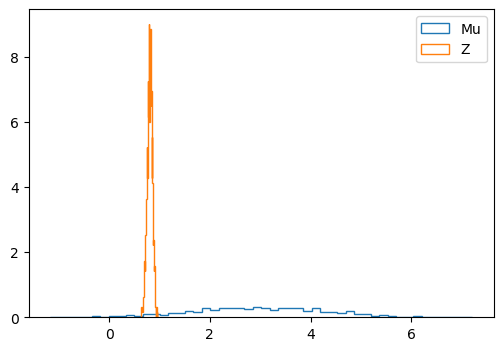

In [12]:
### Single experiment x1000 nominal z
n_data = 500000
mu_test = 1.0


n_exp = 1
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling*mu_test)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])

print(Z_incarnation)

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


out = []
for i in range(0, 10):
    with torch.no_grad():
        
        batch_indices = np.random.permutation(X_data_nom[0].shape[0])
        #print(batch_indices)
        
        
        x_data_sort = X_data_nom[0][batch_indices]
        
        sort_ind = np.argsort(x_data_sort[:,0], axis=0)
        x_data_sort = x_data_sort[sort_ind]

        x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()

        cond_inputs = x_data.repeat((100, 1, 1))
        
        outputs_flow = model.sample(num_samples = 100, noise=None, 
                                    cond_inputs = cond_inputs, 
                                   ).cpu().numpy()*10.0
        out.append(outputs_flow)
out = np.vstack(out)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(out[:,1], histtype='step', label ='Mu', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
c, bins, _ = subplot.hist(out[:,0], histtype='step', label ='Z', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=50)
subplot.legend()


In [145]:
### Single experiment x1000 nominal z
n_data = 500000
mu_test = 1.0


n_exp = 500
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling*mu_test), 2))
#X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling*mu_test)))
#Y_sig_data_nom = np.ones((n_exp, int(n_data_nom)))

Z_incarnation = np.array([z_nominal])

print(Z_incarnation)

centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
#X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))
#Y_back_data_nom = np.zeros((n_exp, int(n_data_nom)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
#weights_data_nom[Y_data_nom==1] *=sigScaling
#weights_data_nom[Y_data_nom==0] *=backScaling


mus_mean, mus_mpv = [], []

for i_exp in range(n_exp):
    out = []
    for i in range(0, 10):
        with torch.no_grad():

            batch_indices = np.random.permutation(X_data_nom[0].shape[0])[:size_batch]
            #print(batch_indices)


            x_data_sort = X_data_nom[0][batch_indices]

            sort_ind = np.argsort(x_data_sort[:,0], axis=0)
            x_data_sort = x_data_sort[sort_ind]

            x_data = torch.tensor(x_data_sort).to(current_settings["device"]).float()
            x_data = x_data.reshape(1,-1)

            cond_inputs = x_data.repeat((10000, 1))


            #cond_inputs = torch.tensor(X_data_nom[0][batch_indices]).to(current_settings["device"]).float()

            #cond_inputs = cond_inputs.view(1, -1)

            outputs_flow = model.sample(num_samples = 10000, noise=None, 
                                        cond_inputs = cond_inputs, 
                                       ).cpu().numpy()*10.0
            out.append(outputs_flow)
    out = np.vstack(out)
    mu_mean = np.mean(out[:,1])

    hist, bin_edges = np.histogram(out[:,1], bins=50, range=(0,2))
    
    #print(hist)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mu_mpv = bin_centers[np.argmax(hist)]
    
    mus_mean.append(mu_mean)
    mus_mpv.append(mu_mpv)
 


[0.78539816]


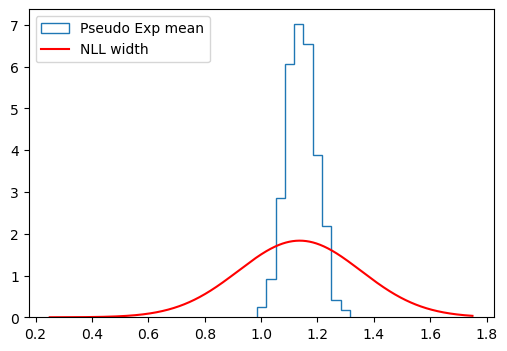

In [148]:
from scipy.stats import norm

mus_mean = np.array(mus_mean)
mus_mpv = np.array(mus_mpv)

x_gauss = np.linspace(0.25, 1.75, 1000)


fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(1,1,1)   

c, bins, _ = subplot.hist(mus_mean, histtype='step', label ='Pseudo Exp mean', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=10)
#c, bins, _ = subplot.hist(mus_mpv, histtype='step', label ='Pseudo Exp mpv', linewidth = 1, linestyle = '-', alpha = 1.0, density=True, bins=bins)

subplot.plot(x_gauss, (norm.pdf((x_gauss-mu_NPE_nom)/sigma_NPE_nom))/sigma_NPE_nom, label='NLL width', color='r')

subplot.legend()

# Coverage Tests


Generate 1000 pseudo experiments, using the same number of events as in the test sample (500k signal and 500k background, but scaled by the class weights of 0.1 and 0.001, resulting in 50k background and 500 signal events. 

As a crosscheck two versions of the data are generated, one in which the nuisance `z` parameter is fixed to the mean `z_nominal` (`X_sig_data_nom` etc.) and one where it is sampled from the prior, with every pseudo experiment having a different `z` that remains consistent for that experiment (`X_sig_data_samp` etc.)


In [92]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 



### Single experiment x1000 nominal z
n_data = 500000

n_exp = 100
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)



### Single experiment x1000 sampled z

n_data_nomsamp = n_data

X_sig_data_nomsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_nomsamp*sigScaling), 2))
Y_sig_data_nomsamp = np.ones((n_exp, int(n_data_nomsamp*sigScaling)))

Z_incarnation = np.random.normal(z_nominal, z_std, n_exp)
centres_sig_data_nomsamp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nomsamp += centres_sig_data_nomsamp


X_back_data_nomsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_nomsamp*backScaling), 2))
Y_back_data_nomsamp = np.zeros((n_exp, int(n_data_nomsamp*backScaling)))

centres_back_data_nomsamp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nomsamp += centres_back_data_nomsamp


X_data_nomsamp = np.concatenate([X_sig_data_nomsamp,X_back_data_nomsamp], 1)
Y_data_nomsamp = np.hstack([Y_sig_data_nomsamp,Y_back_data_nomsamp])
Z_data_nomsamp = np.zeros_like(Y_data_nomsamp) + np.expand_dims(Z_incarnation, 1)

weights_data_nomsamp = np.ones_like(Y_data_nomsamp)


In [94]:
systUp = z_nominal*2.0



### Single experiment x1000 systUpinal z
n_data = 500000

n_exp = 100
n_data_systUp = n_data

X_sig_data_systUp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUp*sigScaling), 2))
Y_sig_data_systUp = np.ones((n_exp, int(n_data_systUp*sigScaling)))

Z_incarnation = np.array([systUp])
centres_sig_data_systUp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_systUp += centres_sig_data_systUp


X_back_data_systUp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUp*backScaling), 2))
Y_back_data_systUp = np.zeros((n_exp, int(n_data_systUp*backScaling)))

centres_back_data_systUp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_systUp += centres_back_data_systUp

X_data_systUp = np.concatenate([X_sig_data_systUp,X_back_data_systUp], 1)
Y_data_systUp = np.hstack([Y_sig_data_systUp,Y_back_data_systUp])
Z_data_systUp = np.zeros_like(Y_data_systUp) + np.expand_dims(Z_incarnation, 1)

weights_data_systUp = np.ones_like(Y_data_systUp)



### Single experiment x1000 sampled z

n_data_systUpsamp = n_data

X_sig_data_systUpsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUpsamp*sigScaling), 2))
Y_sig_data_systUpsamp = np.ones((n_exp, int(n_data_systUpsamp*sigScaling)))

Z_incarnation = np.random.normal(systUp, z_std, n_exp)
centres_sig_data_systUpsamp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_systUpsamp += centres_sig_data_systUpsamp


X_back_data_systUpsamp = np.random.normal(0, feature_std, (n_exp, int(n_data_systUpsamp*backScaling), 2))
Y_back_data_systUpsamp = np.zeros((n_exp, int(n_data_systUpsamp*backScaling)))

centres_back_data_systUpsamp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_systUpsamp += centres_back_data_systUpsamp


X_data_systUpsamp = np.concatenate([X_sig_data_systUpsamp,X_back_data_systUpsamp], 1)
Y_data_systUpsamp = np.hstack([Y_sig_data_systUpsamp,Y_back_data_systUpsamp])
Z_data_systUpsamp = np.zeros_like(Y_data_systUpsamp) + np.expand_dims(Z_incarnation, 1)

weights_data_systUpsamp = np.ones_like(Y_data_systUpsamp)


## Defining new template regions

The original template range did not cover a large enough `z` range to handle all the possible values when sampling from the Gaussian prior. This follows the previous code for setting up the data for the template generation, but extends the range

In [95]:

n_shifts_train = 51
syst_shifts_train = np.arange(-20,31)/10
z_syst_train =  z_nominal * syst_shifts_train



X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_syst_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_syst_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)


X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
Y_syst_train = Y_syst_train.reshape(-1)
Z_syst_train = Z_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


Redefining the previous template functions to use the extended range instead of the previous range. 

In [96]:
mu_values1D = np.arange(0,50)/10



def buildTemplatesTrain(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    
    if not (clfName == "Aware"):
        if (clfName == "Invariant"):
            Y_pred_model = model.predict(X_syst_train, batch_size=4000).reshape(-1)
        elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
            if (clfName == "Augmented") and (~aug_NN):
                Y_pred_model = model.predict_proba(X_syst_train)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_train).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
    
    for z_val in z_syst_train:
        zEvents = np.isclose(Z_syst_train, z_val)

        if (clfName == 'Aware'):
            Y_pred_model = aware_model.predict([X_syst_train[zEvents],Z_syst_train[zEvents]]).reshape(-1)

            hist_sig, bin_array = np.histogram(
                Y_pred_model[Y_syst_train[zEvents]==1], 
                weights=weights_syst_train[zEvents][Y_syst_train[zEvents]==1], range=(0,1), bins=nBins)
            hist_back, bin_array = np.histogram(
                Y_pred_model[Y_syst_train[zEvents]==0], 
                weights=weights_syst_train[zEvents][Y_syst_train[zEvents]==0], range=(0,1), bins=nBins)    
            
        else:
            hist_sig, bin_array = np.histogram(
                Y_pred_model[zEvents &(Y_syst_train==1)], 
                weights=weights_syst_train[zEvents &(Y_syst_train==1)], range=(0,1), bins=nBins)
            hist_back, bin_array = np.histogram(
                Y_pred_model[zEvents &(Y_syst_train==0)], 
                weights=weights_syst_train[zEvents &(Y_syst_train==0)], range=(0,1), bins=nBins)

        sig_hists.append(hist_sig)
        back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists



Modifying the NLL scans to use the extended range and directly return the values for the nuisance parameter `z` and the signal rate `mu` with the lowest NLL

In [97]:
def computeNLL2D_returnMu(obs1D, sH2d, bH2d, mu_values=mu_values1D, z_syst_vals=z_syst):
    min_mu, min_z, minnll = 999,999,999999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst_vals):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    #print ("Min at mu,z: ",min_mu, min_z)
    return nll2D, min_mu, min_z
        
    
    
def computeNLL2D_aware_returnMu(obs2D, sH2d, bH2d, mu_values=mu_values1D, z_syst_vals=z_syst):
    min_mu, min_z, minnll = 999,999,999999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst_vals):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std) # @ToDo: can be moved outside loop
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    #print ("Min at mu,z: ",min_mu, min_z)
    return nll2D, min_mu, min_z
        
        
def createHistObsPredicted(weights, Y_pred,):
    hist_obs, bin_array = np.histogram(Y_pred.reshape(-1), weights=weights.reshape(-1), range=(0,1), bins=nBins)
    return hist_obs, bin_array

def createHistObsAwe(X, weights):
    hist_obs_awe2D = []
    for hyp_z in z_syst_train:
        Y = aware_model.predict([X, np.ones(X.shape[0]) * hyp_z],).reshape(-1)
        hist_obs_awe, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
        hist_obs_awe2D.append(hist_obs_awe)
    hist_obs_awe2D = np.array(hist_obs_awe2D)
    return hist_obs_awe2D

        



In [99]:
print(X_data_nom.shape, X_data_nomsamp.shape)

Y_predict_data_aug_nom, Y_predict_data_aug_nomsamp = [], []

for i in range(X_data_nom.shape[0]):
    Y_predict_data_aug_nom.append(augmented_model.predict_proba(X_data_nom[i])[:,1])
    Y_predict_data_aug_nomsamp.append(augmented_model.predict_proba(X_data_nomsamp[i])[:,1])
    
Y_predict_data_aug_nom = np.array(Y_predict_data_aug_nom)
Y_predict_data_aug_nomsamp = np.array(Y_predict_data_aug_nomsamp)

Y_predict_data_inv_nom = inv_model.predict(X_data_nom, batch_size=4*1024)[:,:,0]
Y_predict_data_inv_nomsamp = inv_model.predict(X_data_nomsamp, batch_size=4*1024)[:,:,0]

Y_predict_data_nom = nominal_model.predict(X_data_nom)
Y_predict_data_nomsamp = nominal_model.predict(X_data_nomsamp)

print(Y_predict_data_aug_nom.shape, Y_predict_data_inv_nom.shape, Y_predict_data_nom.shape)
print(Y_predict_data_aug_nomsamp.shape, Y_predict_data_inv_nomsamp.shape, Y_predict_data_nomsamp.shape)


(100, 50500, 2) (100, 50500, 2)


2023-05-23 14:54:09.690886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:09.905908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:10.313152: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:10.509604: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.
2023-05-23 14:54:10.702312: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1292800000 exceeds 10% of free system memory.


1/1 [==============================] - 2s 2s/step
(100, 50500) (100, 50500) (100, 50500)
(100, 50500) (100, 50500) (100, 50500)


In [102]:
print(X_data_systUp.shape, X_data_systUpsamp.shape)

Y_predict_data_aug_systUp, Y_predict_data_aug_systUpsamp = [], []

for i in range(X_data_systUp.shape[0]):
    Y_predict_data_aug_systUp.append(augmented_model.predict_proba(X_data_systUp[i])[:,1])
    Y_predict_data_aug_systUpsamp.append(augmented_model.predict_proba(X_data_systUpsamp[i])[:,1])
    
Y_predict_data_aug_systUp = np.array(Y_predict_data_aug_systUp)
Y_predict_data_aug_systUpsamp = np.array(Y_predict_data_aug_systUpsamp)

Y_predict_data_inv_systUp = inv_model.predict(X_data_systUp, batch_size=4*1024)[:,:,0]
Y_predict_data_inv_systUpsamp = inv_model.predict(X_data_systUpsamp, batch_size=4*1024)[:,:,0]

Y_predict_data_systUp = nominal_model.predict(X_data_systUp)
Y_predict_data_systUpsamp = nominal_model.predict(X_data_systUpsamp)

print(Y_predict_data_aug_systUp.shape, Y_predict_data_inv_systUp.shape, Y_predict_data_systUp.shape)
print(Y_predict_data_aug_systUpsamp.shape, Y_predict_data_inv_systUpsamp.shape, Y_predict_data_systUpsamp.shape)


(100, 50500, 2) (100, 50500, 2)
1/1 [==============================] - 2s 2s/step
(100, 50500) (100, 50500) (100, 50500)
(100, 50500) (100, 50500) (100, 50500)


Running the NLL scan on each pseudo experiment, and saving the resulting signal rate `mu` for all of them.  This is done for both the nominal and sample nuisance parameter. 

In [103]:
sig_hists_clf, back_hists_clf = buildTemplatesTrain(model=nominal_model, clfName="Nominal")
sig_hists_awe, back_hists_awe = buildTemplatesTrain(model=aware_model, clfName='Aware')

sig_hists_inv, back_hists_inv = buildTemplatesTrain(model=inv_model, clfName="Invariant")
sig_hists_aug, back_hists_aug = buildTemplatesTrain(model=augmented_model, clfName='Augmented')



12750/12750 [==============================] - 26s 2ms/step


In [104]:


mus_clf_nom, mus_awe_nom, mus_inv_nom, mus_aug_nom = [],[],[],[]
mus_clf_nomsamp, mus_awe_nomsamp, mus_inv_nomsamp, mus_aug_nomsamp = [],[],[],[]
#print(sig_hists_awe)


j = 1
#for j in range(0,1):
for j in range(0, weights_data_nomsamp.shape[0]):
    
    hist_obs_nom, bin_array_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_nom[j:j+1])
    hist_obs_nomsamp, bin_array_nomsamp = createHistObsPredicted(weights=weights_data_nomsamp[j:j+1], Y_pred=Y_predict_data_nomsamp[j:j+1])

    hist_obs_aug_nom, bin_array_aug_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_aug_nom[j:j+1])
    hist_obs_aug_nomsamp, bin_array_aug_nomsamp = createHistObsPredicted(weights=weights_data_nomsamp[j:j+1], Y_pred=Y_predict_data_aug_nomsamp[j:j+1])
    
    hist_obs_inv_nom, bin_array_inv_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_inv_nom[j:j+1])
    hist_obs_inv_nomsamp, bin_array_inv_nomsamp = createHistObsPredicted(weights=weights_data_nomsamp[j:j+1], Y_pred=Y_predict_data_inv_nomsamp[j:j+1])
    
    hist_obs_awe2D_nom = createHistObsAwe(X_data_nom[j:j+1], weights=weights_data_nom[j])
    hist_obs_awe2D_nomsamp = createHistObsAwe(X_data_nomsamp[j:j+1], weights=weights_data_nomsamp[j])

    
    nll2D_clf_data_nom, min_mu_clf_nom, min_z_clf_nom = computeNLL2D_returnMu(obs1D=hist_obs_nom, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    nll2D_clf_data_nomsamp, min_mu_clf_nomsamp, min_z_clf_nomsamp = computeNLL2D_returnMu(obs1D=hist_obs_nomsamp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    
    nll2D_aug_data_nom, min_mu_aug_nom, min_z_aug_nom = computeNLL2D_returnMu(obs1D=hist_obs_aug_nom, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    nll2D_aug_data_nomsamp, min_mu_aug_nomsamp, min_z_aug_nomsamp = computeNLL2D_returnMu(obs1D=hist_obs_aug_nomsamp, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    
    nll2D_inv_data_nom, min_mu_inv_nom, min_z_inv_nom = computeNLL2D_returnMu(obs1D=hist_obs_inv_nom, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    nll2D_inv_data_nomsamp, min_mu_inv_nomsamp, min_z_inv_nomsamp = computeNLL2D_returnMu(obs1D=hist_obs_inv_nomsamp, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    
    nll2D_awe_data_nom, min_mu_awe_nom, min_z_awe_nom = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_nom, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)
    nll2D_awe_data_nomsamp, min_mu_awe_nomsamp, min_z_awe_nomsamp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_nomsamp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)

    #print(hist_obs_awe2D_nom, sig_hists_awe, back_hists_awe)
    
    
    mus_clf_nom.append(min_mu_clf_nom)
    mus_clf_nomsamp.append(min_mu_clf_nomsamp)
    mus_aug_nom.append(min_mu_aug_nom)
    mus_aug_nomsamp.append(min_mu_aug_nomsamp)
    mus_inv_nom.append(min_mu_inv_nom)
    mus_inv_nomsamp.append(min_mu_inv_nomsamp)
    mus_awe_nom.append(min_mu_awe_nom)
    mus_awe_nomsamp.append(min_mu_awe_nomsamp)
    

    
    #print(min_mu_clf_nom, min_mu_aug_nom, min_mu_inv_nom, min_mu_awe_nom)
    




In [105]:


mus_clf_systUp, mus_awe_systUp, mus_inv_systUp, mus_aug_systUp = [],[],[],[]
mus_clf_systUpsamp, mus_awe_systUpsamp, mus_inv_systUpsamp, mus_aug_systUpsamp = [],[],[],[]
#print(sig_hists_awe)


j = 1
#for j in range(0,1):
for j in range(0, weights_data_systUpsamp.shape[0]):
    
    hist_obs_systUp, bin_array_systUp = createHistObsPredicted(weights=weights_data_systUp[j:j+1], Y_pred=Y_predict_data_systUp[j:j+1])
    hist_obs_systUpsamp, bin_array_systUpsamp = createHistObsPredicted(weights=weights_data_systUpsamp[j:j+1], Y_pred=Y_predict_data_systUpsamp[j:j+1])

    hist_obs_aug_systUp, bin_array_aug_systUp = createHistObsPredicted(weights=weights_data_systUp[j:j+1], Y_pred=Y_predict_data_aug_systUp[j:j+1])
    hist_obs_aug_systUpsamp, bin_array_aug_systUpsamp = createHistObsPredicted(weights=weights_data_systUpsamp[j:j+1], Y_pred=Y_predict_data_aug_systUpsamp[j:j+1])
    
    hist_obs_inv_systUp, bin_array_inv_systUp = createHistObsPredicted(weights=weights_data_systUp[j:j+1], Y_pred=Y_predict_data_inv_systUp[j:j+1])
    hist_obs_inv_systUpsamp, bin_array_inv_systUpsamp = createHistObsPredicted(weights=weights_data_systUpsamp[j:j+1], Y_pred=Y_predict_data_inv_systUpsamp[j:j+1])
    
    hist_obs_awe2D_systUp = createHistObsAwe(X_data_systUp[j:j+1], weights=weights_data_systUp[j])
    hist_obs_awe2D_systUpsamp = createHistObsAwe(X_data_systUpsamp[j:j+1], weights=weights_data_systUpsamp[j])

    
    nll2D_clf_data_systUp, min_mu_clf_systUp, min_z_clf_systUp = computeNLL2D_returnMu(obs1D=hist_obs_systUp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    nll2D_clf_data_systUpsamp, min_mu_clf_systUpsamp, min_z_clf_systUpsamp = computeNLL2D_returnMu(obs1D=hist_obs_systUpsamp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    
    nll2D_aug_data_systUp, min_mu_aug_systUp, min_z_aug_systUp = computeNLL2D_returnMu(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    nll2D_aug_data_systUpsamp, min_mu_aug_systUpsamp, min_z_aug_systUpsamp = computeNLL2D_returnMu(obs1D=hist_obs_aug_systUpsamp, sH2d=sig_hists_aug, bH2d=back_hists_aug, z_syst_vals=z_syst_train)
    
    nll2D_inv_data_systUp, min_mu_inv_systUp, min_z_inv_systUp = computeNLL2D_returnMu(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    nll2D_inv_data_systUpsamp, min_mu_inv_systUpsamp, min_z_inv_systUpsamp = computeNLL2D_returnMu(obs1D=hist_obs_inv_systUpsamp, sH2d=sig_hists_inv, bH2d=back_hists_inv, z_syst_vals=z_syst_train)
    
    nll2D_awe_data_systUp, min_mu_awe_systUp, min_z_awe_systUp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)
    nll2D_awe_data_systUpsamp, min_mu_awe_systUpsamp, min_z_awe_systUpsamp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_systUpsamp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)

    #print(hist_obs_awe2D_systUp, sig_hists_awe, back_hists_awe)
    
    
    mus_clf_systUp.append(min_mu_clf_systUp)
    mus_clf_systUpsamp.append(min_mu_clf_systUpsamp)
    mus_aug_systUp.append(min_mu_aug_systUp)
    mus_aug_systUpsamp.append(min_mu_aug_systUpsamp)
    mus_inv_systUp.append(min_mu_inv_systUp)
    mus_inv_systUpsamp.append(min_mu_inv_systUpsamp)
    mus_awe_systUp.append(min_mu_awe_systUp)
    mus_awe_systUpsamp.append(min_mu_awe_systUpsamp)
    

    
    #print(min_mu_clf_systUp, min_mu_aug_systUp, min_mu_inv_systUp, min_mu_awe_systUp)
    




Plotting the resulting `mu` distributions for the nominal `z` value (red), and the sampled `z` value (green) and comparing it to a Gaussian distribution with a width and mean derived from the NLL profile (blue). For reference fits of Gaussian distributions to the histogram data are included, sharing a color with the histograms.

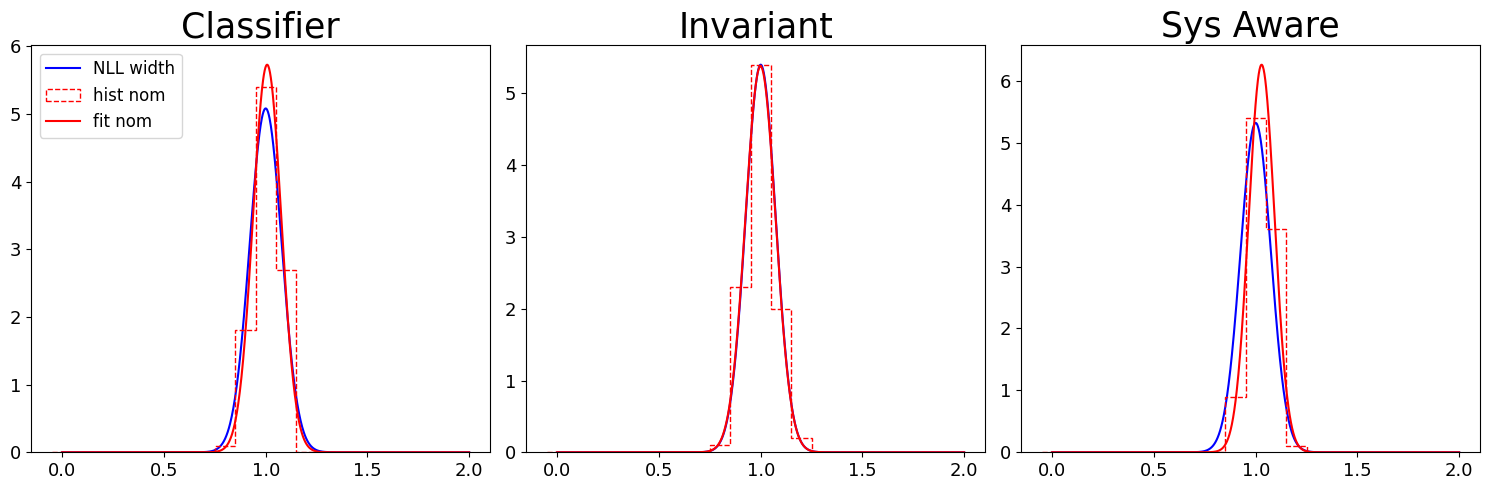

In [133]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom)


subplot1.hist(mus_clf_nom, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom', histtype='step', color='r', ls='--')
subplot2.hist(mus_inv_nom, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom', histtype='step', color='r', ls='--')
subplot3.hist(mus_awe_nom, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom', histtype='step', color='r', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom), label='fit nom', color='r')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_nom))/np.std(mus_inv_nom)))/np.std(mus_inv_nom), label='fit nom', color='r')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_nom))/np.std(mus_awe_nom)))/np.std(mus_awe_nom), label='fit nom', color='r')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('nom.png')

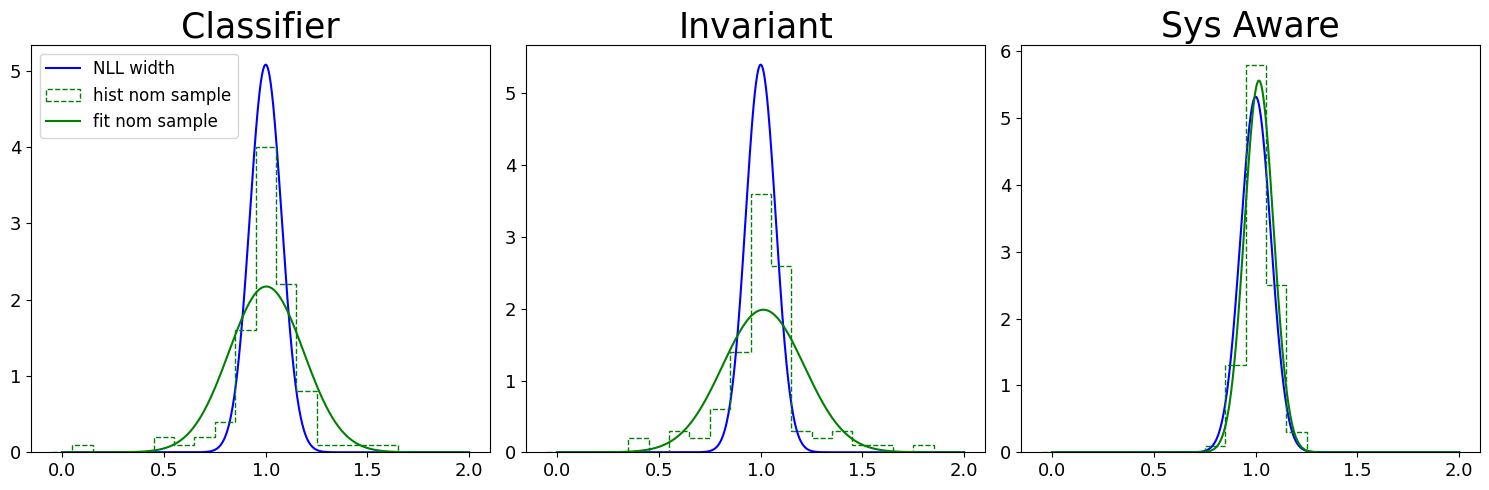

In [132]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom)


subplot1.hist(mus_clf_nomsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom sample', histtype='step', color='g', ls='--')
subplot2.hist(mus_inv_nomsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom sample', histtype='step', color='g', ls='--')
subplot3.hist(mus_awe_nomsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist nom sample', histtype='step', color='g', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_nomsamp))/np.std(mus_clf_nomsamp)))/np.std(mus_clf_nomsamp), label='fit nom sample', color='g')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_nomsamp))/np.std(mus_inv_nomsamp)))/np.std(mus_inv_nomsamp), label='fit nom sample', color='g')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_nomsamp))/np.std(mus_awe_nomsamp)))/np.std(mus_awe_nomsamp), label='fit nom sample', color='g')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('nomsamp.png')

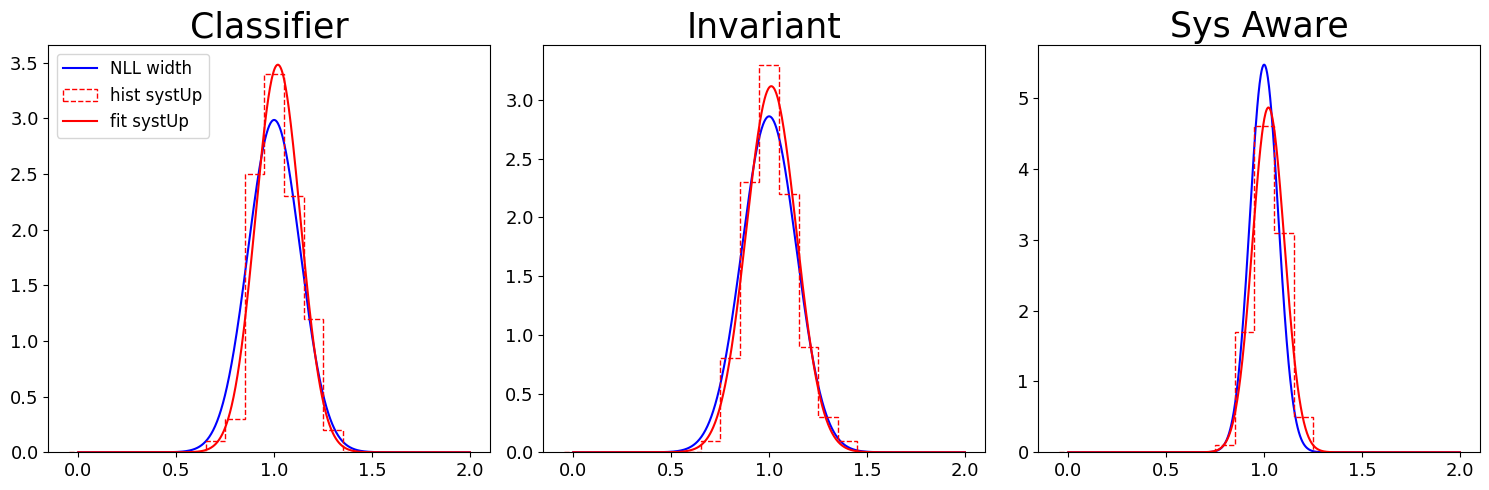

In [131]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_systUp))/sigma_inv_systUp, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_systUp))/sigma_awe_systUp, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_systUp))/np.std(mus_clf_systUp)))/np.std(mus_clf_systUp)


subplot1.hist(mus_clf_systUp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp', histtype='step', color='r', ls='--')
subplot2.hist(mus_inv_systUp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp', histtype='step', color='r', ls='--')
subplot3.hist(mus_awe_systUp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp', histtype='step', color='r', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_systUp))/np.std(mus_clf_systUp)))/np.std(mus_clf_systUp), label='fit systUp', color='r')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_systUp))/np.std(mus_inv_systUp)))/np.std(mus_inv_systUp), label='fit systUp', color='r')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_systUp))/np.std(mus_awe_systUp)))/np.std(mus_awe_systUp), label='fit systUp', color='r')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('systUp.png')

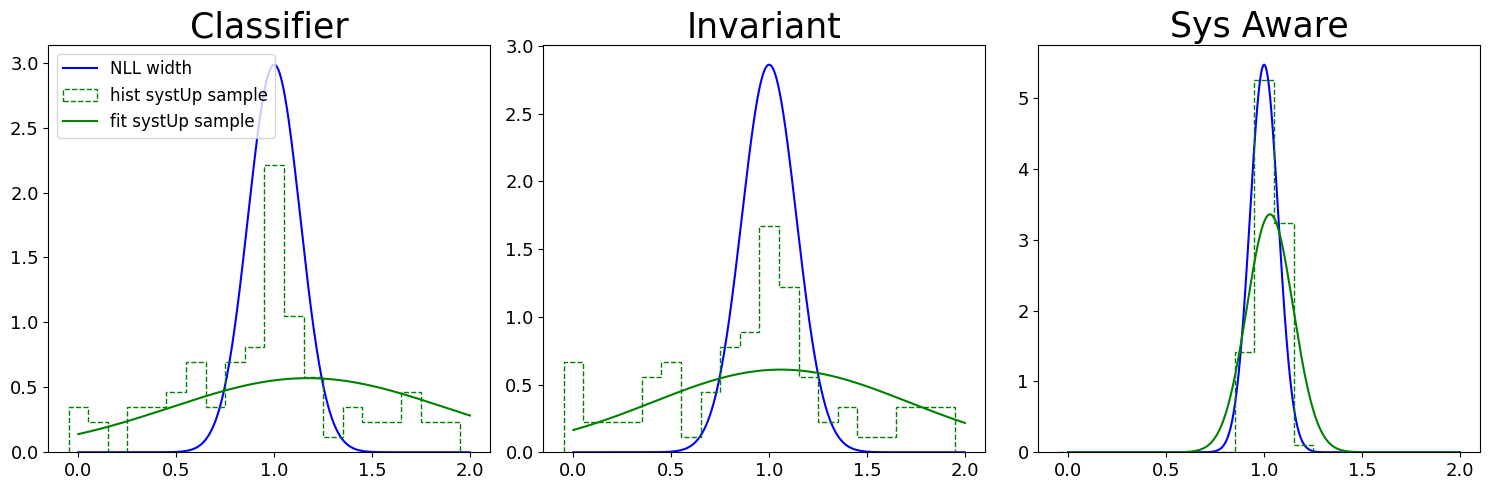

In [134]:
from scipy.stats import norm


fig = plt.figure(figsize=(15,5))
subplot1 = fig.add_subplot(1,3,1)  
subplot2 = fig.add_subplot(1,3,2)  
subplot3 = fig.add_subplot(1,3,3)  

x_gauss = np.linspace(0.0, 2.0, 1000)


y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp

subplot1.title.set_text('Classifier')
subplot2.title.set_text('Invariant')
subplot3.title.set_text('Sys Aware')

subplot1.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_clf_systUp))/sigma_clf_systUp, label='NLL width', color='b')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_inv_systUp))/sigma_inv_systUp, label='NLL width', color='b')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-1)/sigma_awe_systUp))/sigma_awe_systUp, label='NLL width', color='b')


y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_systUp))/np.std(mus_clf_systUp)))/np.std(mus_clf_systUp)


subplot1.hist(mus_clf_systUpsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp sample', histtype='step', color='g', ls='--')
subplot2.hist(mus_inv_systUpsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp sample', histtype='step', color='g', ls='--')
subplot3.hist(mus_awe_systUpsamp, bins=np.arange(-0.05, 2.05, 0.1), density = True, label='hist systUp sample', histtype='step', color='g', ls='--')



subplot1.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_clf_systUpsamp))/np.std(mus_clf_systUpsamp)))/np.std(mus_clf_systUpsamp), label='fit systUp sample', color='g')
subplot2.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_inv_systUpsamp))/np.std(mus_inv_systUpsamp)))/np.std(mus_inv_systUpsamp), label='fit systUp sample', color='g')
subplot3.plot(x_gauss, (norm.pdf((x_gauss-np.mean(mus_awe_systUpsamp))/np.std(mus_awe_systUpsamp)))/np.std(mus_awe_systUpsamp), label='fit systUp sample', color='g')


subplot1.legend(loc = 'upper left', fontsize=12)
plt.savefig('systUpsamp.png')

0.084829240241794 0.09402578471369638
0.34106304402558774 0.09402578471369638


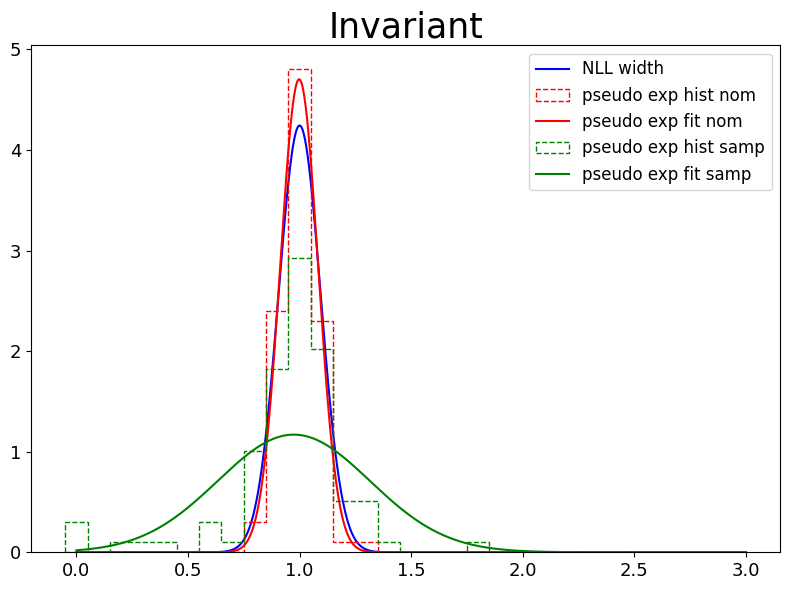

In [100]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom
print(np.std(mus_inv_nom), sigma_inv_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_inv_nom))/np.std(mus_inv_nom)))/np.std(mus_inv_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_inv_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_inv_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_inv_nom))/sigma_inv_nom
print(np.std(mus_inv_samp), sigma_inv_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_inv_samp))/np.std(mus_inv_samp)))/np.std(mus_inv_samp)

subplot.title.set_text('Invariant')

subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


0.08 0.09053964630475846
0.33670610330078665 0.09053964630475846


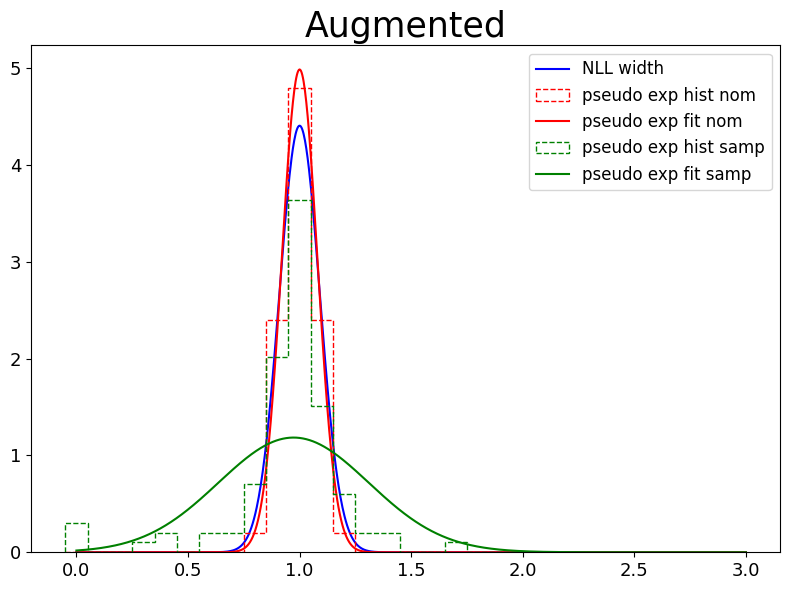

In [101]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_aug_nom))/sigma_aug_nom
print(np.std(mus_aug_nom), sigma_aug_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_aug_nom))/np.std(mus_aug_nom)))/np.std(mus_aug_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_aug_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_aug_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_aug_nom))/sigma_aug_nom
print(np.std(mus_aug_samp), sigma_aug_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_aug_samp))/np.std(mus_aug_samp)))/np.std(mus_aug_samp)

subplot.title.set_text('Augmented')

subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


0.07110555533852472 0.07599512614254623
0.06837397165588674 0.07599512614254623


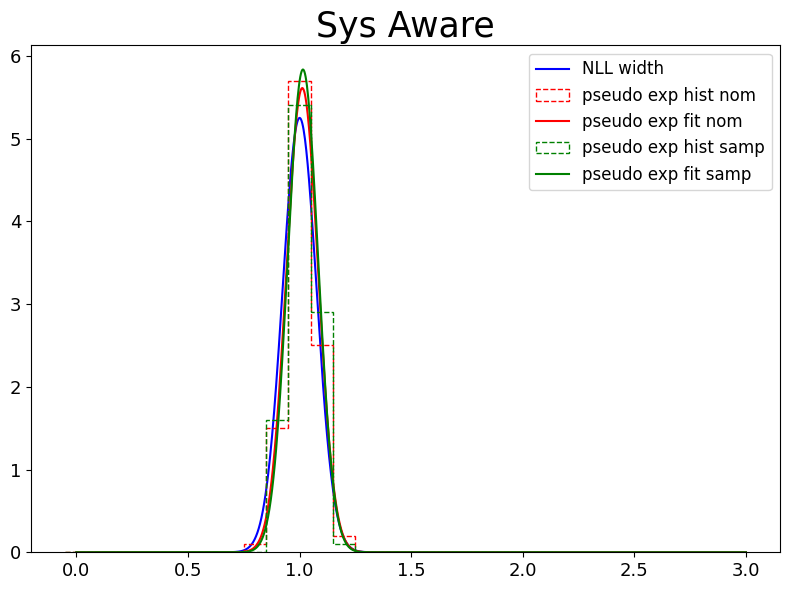

In [102]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom
print(np.std(mus_awe_nom), sigma_awe_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_awe_nom))/np.std(mus_awe_nom)))/np.std(mus_awe_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_awe_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_awe_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom
print(np.std(mus_awe_samp), sigma_awe_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_awe_samp))/np.std(mus_awe_samp)))/np.std(mus_awe_samp)

subplot.title.set_text('Sys Aware')

subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


In [ ]:
mus = np.array(mus)


cov_1sig = sum(abs(mus-1) < sigma_clf_samp)/n_exp
cov_2sig = sum(abs(mus-1) < sigma_clf_samp*2)/n_exp
cov_3sig = sum(abs(mus-1) < sigma_clf_samp*3)/n_exp

print('1 Sigma: {:.2f} \n'.format(cov_1sig) + 
      '2 Sigma: {:.2f} \n'.format(cov_2sig) + 
      '3 Sigma: {:.2f} '.format(cov_3sig))
    
    

